## Mount Google Drive


In [ ]:
import os
import sys
from google.colab import drive

# Change according to your google drive's file path
workdir = "/content/drive/MyDrive/Internship/Diabetes(NSTEMI)/Development"

try:
    # Mount Drive
    drive.mount('/content/drive', force_remount=True) # Make sure it remounts even if already mounted

    # Change Current Directory
    os.chdir(workdir)
    print("Current Working Directory: ", os.getcwd()) # Show current directory path

except Exception as e:
    print("Error: Failed to Mount Google Drive : ", e)

Mounted at /content/drive
Current Working Directory:  /content/drive/MyDrive/Internship/Diabetes(NSTEMI)/Development


## Import Library

In [ ]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score

## Import Datasets

In [ ]:
X_train = joblib.load('./split/X_train.pkl')
y_train = joblib.load('./split/y_train.pkl')
X_test = joblib.load('./split/X_test.pkl')
y_test = joblib.load('./split/y_test.pkl')
timi_nstemi_test = joblib.load('./split/timi_nstemi_test.pkl')

## Backward Elimination

In [ ]:
# Backward Elimination Function
# Parameters can be fine tuned in the model classifier
def backward_elimination(
    X_train, y_train, X_test, y_test,
    model_types=['xgb', 'lr', 'rf', 'svm'],
    min_features=5, # stop when only this many features are left
    imbalance_ratio=1.0  # only for XGB # death and alive are same important
):
    results = {}

    for model_type in model_types:
        print(f"\nRunning Backward Elimination for {model_type.upper()}")

        features = list(X_train.columns)
        performance_history = []

        while len(features) > min_features:
            # Model selector
            if model_type == 'xgb':
                model = XGBClassifier(
                    objective='binary:logistic', # y is 0/1
                    eval_metric='auc',
                    scale_pos_weight=imbalance_ratio,
                    learning_rate=0.1, # how much the model updates per boosting step
                    n_estimators=150, # number of trees to build
                    max_depth=1,
                    use_label_encoder=False, # dont automatically apply a label encoder ie. alive=0, death=1
                    enable_categorical=True, # treat features with a categorical data type as categorical variables
                    verbosity=0, # suppresses training logs
                    random_state=42
                )

            elif model_type == 'lr':
                model = LogisticRegression(
                    penalty='l2', # adding a constraint (L2) to the model’s coefficients to prevent them from becoming too large
                    C=0.5, # how strong the penalty is (smaller number = stronger penalty)
                    solver='liblinear',
                    max_iter=150, # times of repetition
                    random_state=42
                )

            elif model_type == 'rf':
                model = RandomForestClassifier(
                    n_estimators=150,
                    max_depth=1,
                    max_features='sqrt', #  √ randomly selected features at each split
                    bootstrap=True, # train with random sample with replacement from the training data
                    random_state=42
                )

            elif model_type == 'svm':
                model = LinearSVC(
                    penalty='l1',
                    C=0.3,
                    max_iter=150,
                    dual=False,
                    random_state=42
                )

            else:
                raise ValueError(f"Unknown model type: {model_type}")

            # Fit model
            model.fit(X_train[features], y_train)

            # Predict probabilities or scores
            if model_type in ['lr', 'rf']:
                y_proba = model.predict_proba(X_test[features])[:, 1] # [:, 1]: returns only probabilities for death
            elif model_type == 'svm':
                y_scores = model.decision_function(X_test[features]) # LinearSVC does not have predict_proba()
                y_proba = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())  # Normalize to [0, 1]
            elif model_type == 'xgb':
                y_proba = model.predict_proba(X_test[features])[:, 1]

            auc = roc_auc_score(y_test, y_proba) # measures model quality
            performance_history.append((len(features), auc, list(features)))

            # Feature importance logic
            if model_type == 'xgb':
                importances = model.feature_importances_ # gives a score to each feature based on how often and how effectively it was used for splitting
            elif model_type == 'rf':
                importances = model.feature_importances_
            elif model_type == 'lr':
                importances = np.abs(model.coef_[0]) # gets the array of weights for the first class and converts all weights to positive numbers (absolute values)
            elif model_type == 'svm':
                importances = np.abs(model.coef_[0])
            else:
                raise ValueError("Unsupported model type for feature importance.")

            # Remove least important feature
            least_important_idx = np.argmin(importances) # np.argmin: finds the index of the smallest value.
            least_important_feature = features[least_important_idx]
            print(f"Removed: {least_important_feature}, AUC: {auc:.4f}") # 4f: 4 decimal places
            features.remove(least_important_feature)

        results[model_type] = {
            'selected_features': features,
            'performance_history': performance_history
        }

    return results


In [ ]:
# Fixing label type error
y_train = y_train.astype(int) #  converts data type to int, prevent error
y_test = y_test.astype(int)

# LR RF and SVM
results = backward_elimination(
    X_train, y_train, X_test, y_test,
    model_types=[ 'lr', 'rf', 'svm']
)


Running Backward Elimination for LR
Removed: cpremcvd, AUC: 0.7814
Removed: ccap, AUC: 0.7814
Removed: fbstatus, AUC: 0.7813
Removed: smokingstatus, AUC: 0.7813
Removed: hdlc, AUC: 0.7816
Removed: ecgabnormlocationil, AUC: 0.7815
Removed: ecgabnormlocationll, AUC: 0.7814
Removed: ldlc, AUC: 0.7822
Removed: bpdias, AUC: 0.7820
Removed: tg, AUC: 0.7816
Removed: asa, AUC: 0.7811
Removed: ecgabnormtypestelev1, AUC: 0.7818
Removed: heartrate, AUC: 0.7822
Removed: canginamt2wk, AUC: 0.7793
Removed: ecgabnormlocationrv, AUC: 0.7792
Removed: ptsex, AUC: 0.7793
Removed: lmwh, AUC: 0.7805
Removed: heparin, AUC: 0.7812
Removed: canginapast2wk, AUC: 0.7814
Removed: fbg, AUC: 0.7824
Removed: ptageatnotification, AUC: 0.7762
Removed: cheartfail, AUC: 0.7708
Removed: ptrace, AUC: 0.7717
Removed: cmi, AUC: 0.7676
Removed: tc, AUC: 0.7671
Removed: ck, AUC: 0.7681
Removed: cdys, AUC: 0.7613
Removed: cpvascular, AUC: 0.7624
Removed: ecgabnormtypetwave, AUC: 0.7627
Removed: clung, AUC: 0.7602
Removed: ch

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: smokingstatus, AUC: 0.7735


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: fbstatus, AUC: 0.7733


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: cpremcvd, AUC: 0.7733


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: ecgabnormtypestelev1, AUC: 0.7729


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: ecgabnormlocationrv, AUC: 0.7733


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: hdlc, AUC: 0.7733


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: ecgabnormlocationil, AUC: 0.7735


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: canginamt2wk, AUC: 0.7735


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: ldlc, AUC: 0.7735


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: ccap, AUC: 0.7733


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: ecgabnormlocationll, AUC: 0.7733


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: tg, AUC: 0.7733


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: asa, AUC: 0.7730


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: lmwh, AUC: 0.7735


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: heartrate, AUC: 0.7737


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: bpdias, AUC: 0.7711


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: ptsex, AUC: 0.7711


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: cheartfail, AUC: 0.7722


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: heparin, AUC: 0.7725


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: ptageatnotification, AUC: 0.7727


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: ptrace, AUC: 0.7673


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: cmi, AUC: 0.7637


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: fbg, AUC: 0.7632


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: canginapast2wk, AUC: 0.7578


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: tc, AUC: 0.7593


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: cardiaccath, AUC: 0.7593


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: ecgabnormtypetwave, AUC: 0.7530


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: cdys, AUC: 0.7509


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: clung, AUC: 0.7518


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: ck, AUC: 0.7516


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: ecgabnormlocational, AUC: 0.7429


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: ecgabnormtypestelev2, AUC: 0.7463
Removed: chpt, AUC: 0.7481
Removed: statin, AUC: 0.7481


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: insulin, AUC: 0.7445
Removed: cabg, AUC: 0.7433


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: ecgabnormlocationtp, AUC: 0.7443
Removed: bpsys, AUC: 0.7457


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: ecgabnormtypestdep, AUC: 0.7167
Removed: ecgabnormtypebbb, AUC: 0.7187


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: diuretic, AUC: 0.7187
Removed: cpvascular, AUC: 0.7291


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: ccerebrovascular, AUC: 0.7290
Removed: antiarr, AUC: 0.7267


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Removed: acsstratum, AUC: 0.7195
Removed: lipidla, AUC: 0.7197
Removed: crenal, AUC: 0.7181
Removed: pci, AUC: 0.7112
Removed: acei, AUC: 0.6925
Removed: oralhypogly, AUC: 0.7089
Removed: bb, AUC: 0.7171


In [ ]:
# Calculate imbalance ratio
pos = sum(y_train == 1)
neg = sum(y_train == 0)
imbalance_ratio = neg / pos

print(f"Dead: {pos}")
print(f"Alive: {neg}")
print(f"Imbalance Ratio: {imbalance_ratio:.2f}")

# Convert all object columns to category (FOR XGBoost compatibility) # XGB can handle categorical features only if their dtype is 'category'
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col] = X_train[col].astype('category')
        X_test[col] = X_test[col].astype('category')

xgb_results = backward_elimination(
    X_train, y_train, X_test, y_test,
    model_types=[ 'xgb' ],
    imbalance_ratio=imbalance_ratio
)

Dead: 516
Alive: 10954
Imbalance Ratio: 21.23

Running Backward Elimination for XGB
Removed: smokingstatus, AUC: 0.8151
Removed: fbstatus, AUC: 0.8151
Removed: acsstratum, AUC: 0.8151
Removed: ptsex, AUC: 0.8151
Removed: cdys, AUC: 0.8151
Removed: cdm, AUC: 0.8151
Removed: chpt, AUC: 0.8151
Removed: cpremcvd, AUC: 0.8151
Removed: cmi, AUC: 0.8151
Removed: ccap, AUC: 0.8151
Removed: canginamt2wk, AUC: 0.8151
Removed: canginapast2wk, AUC: 0.8151
Removed: cheartfail, AUC: 0.8151
Removed: clung, AUC: 0.8151
Removed: ccerebrovascular, AUC: 0.8151
Removed: cpvascular, AUC: 0.8151
Removed: ecgabnormtypestelev1, AUC: 0.8151
Removed: ecgabnormtypestelev2, AUC: 0.8151
Removed: ecgabnormtypetwave, AUC: 0.8151
Removed: ecgabnormtypebbb, AUC: 0.8151
Removed: ecgabnormlocationil, AUC: 0.8151
Removed: ecgabnormlocational, AUC: 0.8151
Removed: ecgabnormlocationll, AUC: 0.8151
Removed: ecgabnormlocationtp, AUC: 0.8151
Removed: ecgabnormlocationrv, AUC: 0.8151
Removed: cabg, AUC: 0.8151
Removed: asa, AU

## Analysis

[LR] Best AUC: 0.7824 with 37 features


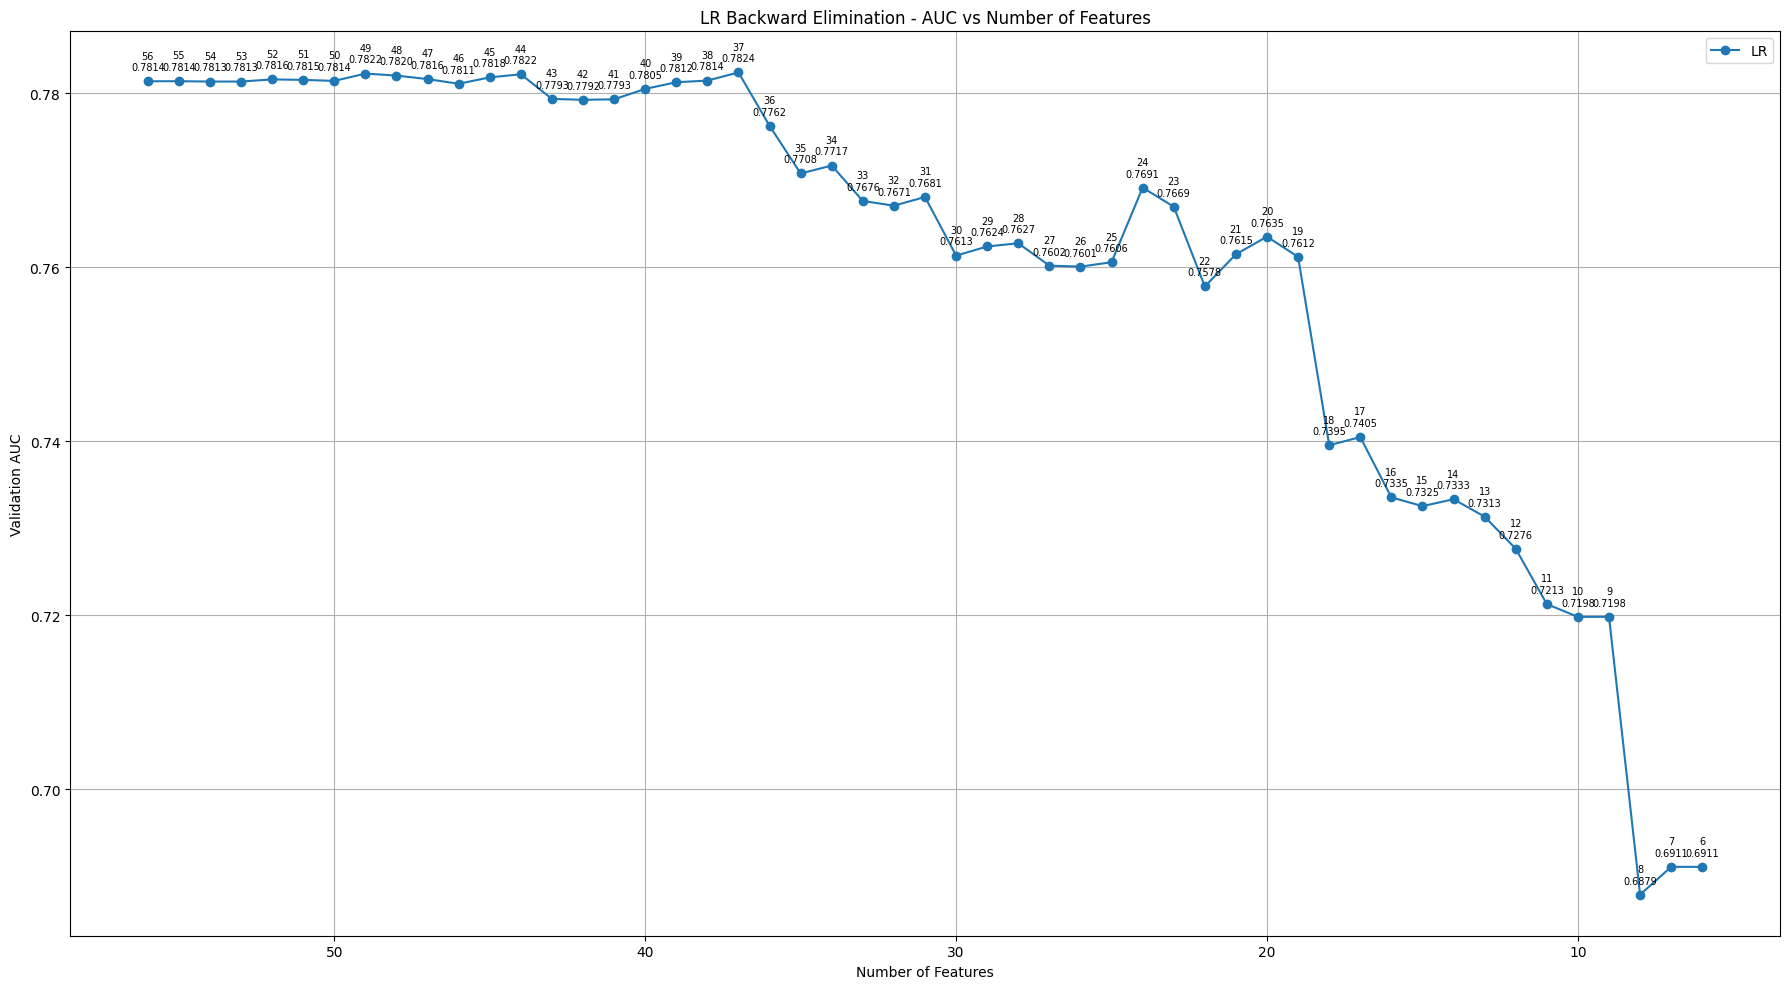

In [ ]:
# Extract history for a specific model
model_key = 'lr'
history = results[model_key]['performance_history']

# Find best AUC and corresponding number of features
best_num_features, best_auc, best_features = max(history, key=lambda x: x[1]) # max(): finds the tuple with the largest value based on the key function # lambda x: x[1]: look at index 1 (the AUC) in each tuple
print(f"[{model_key.upper()}] Best AUC: {best_auc:.4f} with {best_num_features} features")

# Prepare plot data
sizes, aucs, _ = zip(*history) # *: unpack, zip: groups first elements together and so on
adjusted_aucs = [auc for auc in aucs]  # If you added offset for display

# Plot
plt.figure(figsize=(18, 10))
plt.plot(sizes, adjusted_aucs, marker='o', label=model_key.upper()) # x: sizes y: adjusted_aucs # label:  legend label
plt.title(f"{model_key.upper()} Backward Elimination - AUC vs Number of Features")
plt.xlabel("Number of Features")
plt.ylabel("Validation AUC")
plt.grid(True)
plt.gca().invert_xaxis()  # Optional: show decreasing features on X-axis
plt.legend()

# Annotate each point
for (x, y, raw_auc) in zip(sizes, adjusted_aucs, aucs):
    plt.annotate(f"{x}\n{raw_auc:.4f}", (x, y), textcoords="offset points", xytext=(0, 8), ha='center', fontsize=7) # textcoords="offset points": move from the data point not from axis

plt.tight_layout()

plt.show()

[RF] Best AUC: 0.7950 with 45 features


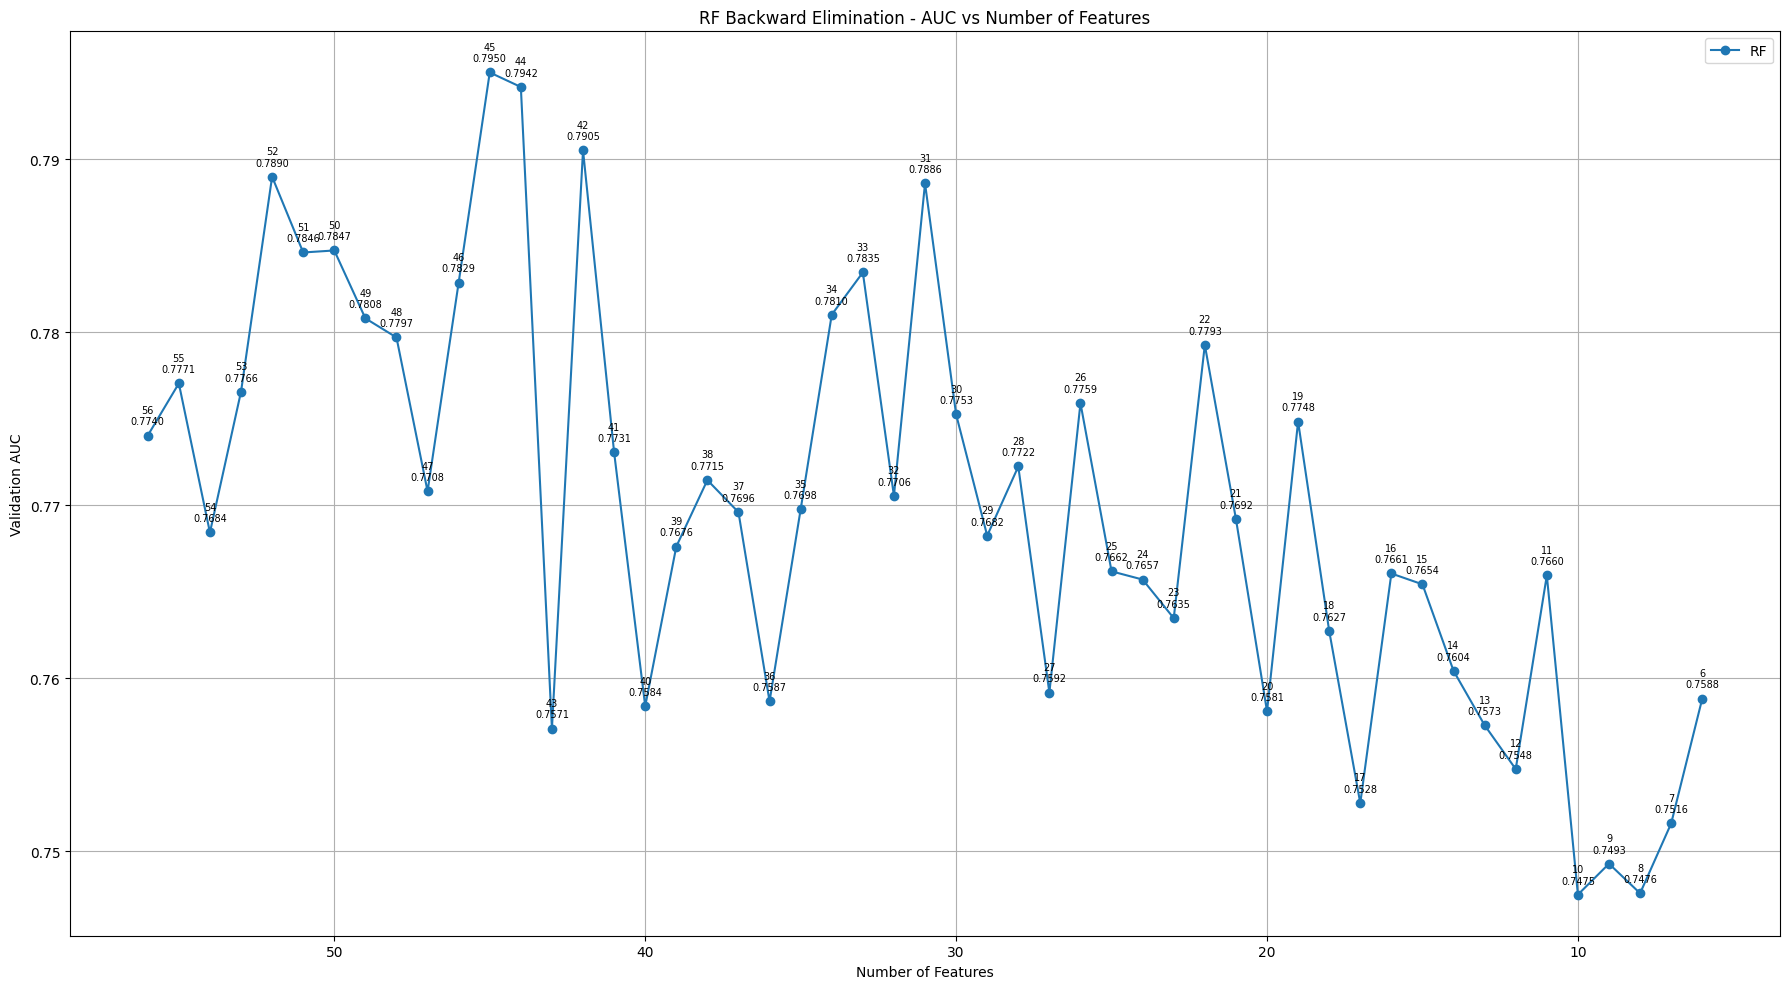

In [ ]:
# Extract history for a specific model
model_key = 'rf'
history = results[model_key]['performance_history']

# Find best AUC and corresponding number of features
best_num_features, best_auc, best_features = max(history, key=lambda x: x[1])
print(f"[{model_key.upper()}] Best AUC: {best_auc:.4f} with {best_num_features} features")

# Prepare plot data
sizes, aucs, _ = zip(*history)
adjusted_aucs = [auc for auc in aucs]  # If you added offset for display

# Plot
plt.figure(figsize=(18, 10))
plt.plot(sizes, adjusted_aucs, marker='o', label=model_key.upper())
plt.title(f"{model_key.upper()} Backward Elimination - AUC vs Number of Features")
plt.xlabel("Number of Features")
plt.ylabel("Validation AUC")
plt.grid(True)
plt.gca().invert_xaxis()  # Optional: show decreasing features on X-axis
plt.legend()

# Annotate each point
for (x, y, raw_auc) in zip(sizes, adjusted_aucs, aucs):
    plt.annotate(f"{x}\n{raw_auc:.4f}", (x, y), textcoords="offset points", xytext=(0, 8), ha='center', fontsize=7)

plt.tight_layout()

plt.show()

[SVM] Best AUC: 0.7737 with 42 features


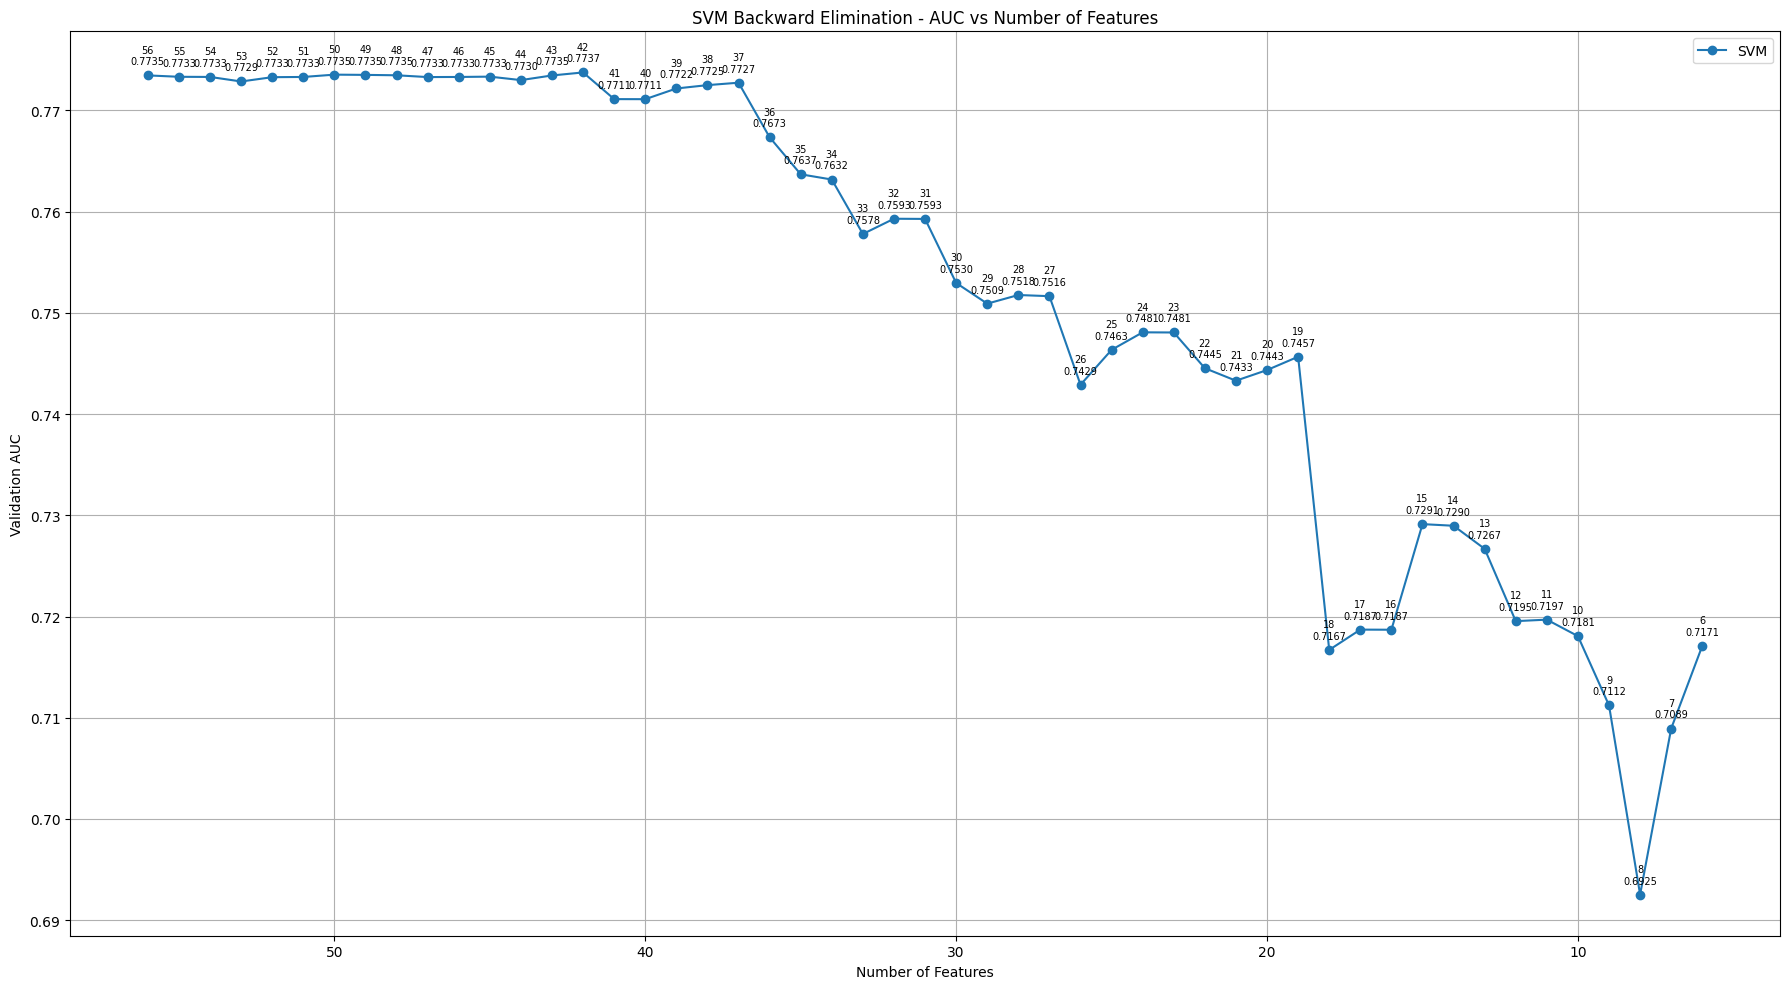

In [ ]:
# Extract history for a specific model
model_key = 'svm'
history = results[model_key]['performance_history']

# Find best AUC and corresponding number of features
best_num_features, best_auc, best_features = max(history, key=lambda x: x[1])
print(f"[{model_key.upper()}] Best AUC: {best_auc:.4f} with {best_num_features} features")

# Prepare plot data
sizes, aucs, _ = zip(*history)
adjusted_aucs = [auc for auc in aucs]  # If you added offset for display

# Plot
plt.figure(figsize=(18, 10))
plt.plot(sizes, adjusted_aucs, marker='o', label=model_key.upper())
plt.title(f"{model_key.upper()} Backward Elimination - AUC vs Number of Features")
plt.xlabel("Number of Features")
plt.ylabel("Validation AUC")
plt.grid(True)
plt.gca().invert_xaxis()  # Optional: show decreasing features on X-axis
plt.legend()

# Annotate each point
for (x, y, raw_auc) in zip(sizes, adjusted_aucs, aucs):
    plt.annotate(f"{x}\n{raw_auc:.4f}", (x, y), textcoords="offset points", xytext=(0, 8), ha='center', fontsize=7)

plt.tight_layout()

plt.show()

[XGB] Best AUC: 0.8156 with 21 features


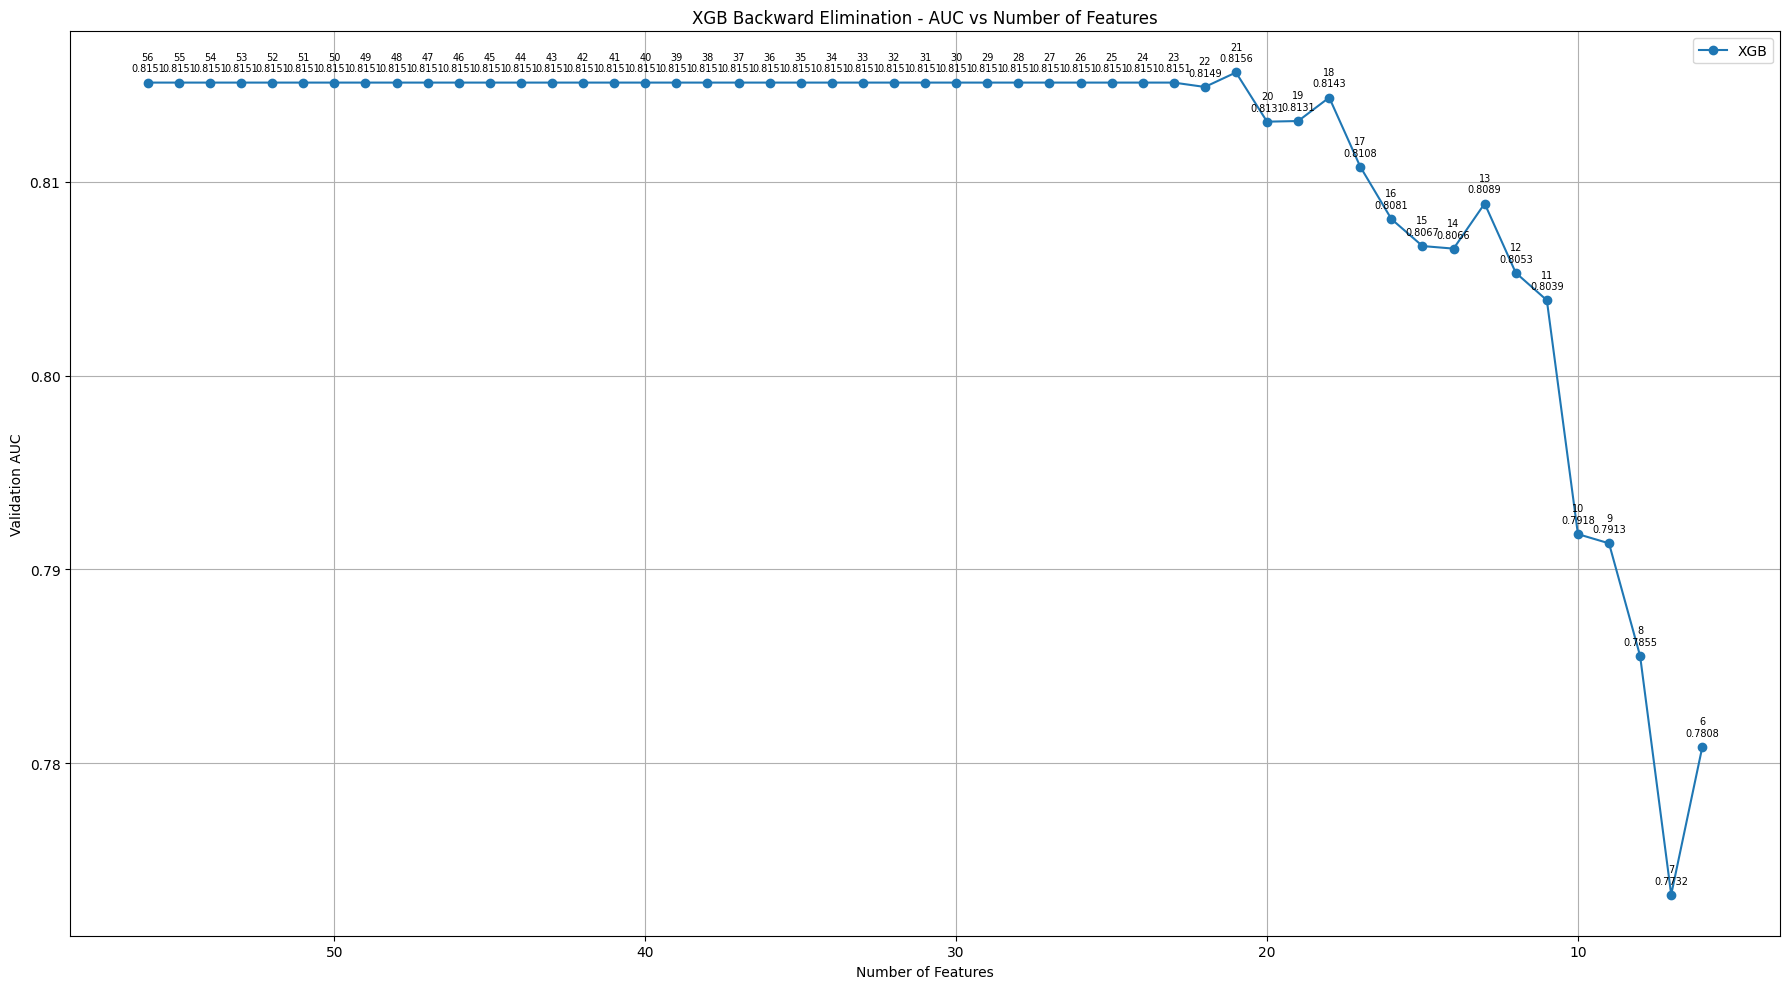

In [ ]:
# Extract history for a specific model
model_key = 'xgb'
history = xgb_results[model_key]['performance_history']

# Find best AUC and corresponding number of features
best_num_features, best_auc, best_features = max(history, key=lambda x: x[1])
print(f"[{model_key.upper()}] Best AUC: {best_auc:.4f} with {best_num_features} features")

# Prepare plot data
sizes, aucs, _ = zip(*history)
adjusted_aucs = [auc for auc in aucs]  # If you added offset for display

# Plot
plt.figure(figsize=(18, 10))
plt.plot(sizes, adjusted_aucs, marker='o', label=model_key.upper())
plt.title(f"{model_key.upper()} Backward Elimination - AUC vs Number of Features")
plt.xlabel("Number of Features")
plt.ylabel("Validation AUC")
plt.grid(True)
plt.gca().invert_xaxis()  # Optional: show decreasing features on X-axis
plt.legend()

# Annotate each point
for (x, y, raw_auc) in zip(sizes, adjusted_aucs, aucs):
    plt.annotate(f"{x}\n{raw_auc:.4f}", (x, y), textcoords="offset points", xytext=(0, 8), ha='center', fontsize=7)

plt.tight_layout()


plt.show()

## Get the Best Selected Features

In [ ]:
# Get performance history for XGB
xgb_history = xgb_results['xgb']['performance_history']

# Find the step with N features and the best AUC among them (CHange accordingly)
best_at_16 = max([entry for entry in xgb_history if entry[0] == 16], key=lambda x: x[1])
num_feats, best_auc, best_features = best_at_21

print(f"Best AUC: {best_auc:.4f}")
print("Selected features:")
print(best_features)


Best AUC: 0.8081
Selected features:
['ptageatnotification', 'killipclass', 'crenal', 'cardiaccath', 'pci', 'bb', 'acei', 'arb', 'calcantagonist', 'bpsys', 'bpdias', 'ck', 'tc', 'ldlc', 'tg', 'fbg']


In [ ]:
# Save list
joblib.dump(best_features, './selected_features/best_features.pkl')

['./selected_features/best_features.pkl']